# Exploring Overture Map data
This notebook explores the Buildings and Places Themes of Overture Maps Data. The layers are first saved locally as GeoParquet files and then read as Dask DataFrames. A spatial subset is then created and saved as ShapeFile, to be later used in the GIS tool of your choice.
## About Overture Maps Data
Website: [Overture Maps Foundations](https://overturemaps.org/)

Github Repository: [How to access data](https://github.com/OvertureMaps/data/blob/main/README.md#how-to-access-overture-maps-data)

### Other resources
Overture Open Buildings GeoParquet split by country hosted by Source Cooperative: https://beta.source.coop/repositories/cholmes/overture/description/

Online visualisation tool of the Places Theme: https://bdon.github.io/overture-tiles/places.html#0.86/0/0

## How to run this notebook
1. Download the parquet file: Either download the full Theme by following instructions [here](https://github.com/OvertureMaps/data/blob/main/README.md#5-download-the-parquet-files), or download file of one country [from Source Cooperative](https://beta.source.coop/repositories/cholmes/overture/description/)
2. Install the library `dask-geopandas`. Documentation and installation instructions [here](https://dask-geopandas.readthedocs.io/en/stable/index.html). The library is needed to get a spatial subset of the Dask DataFrame, and to save it as ShapeFile


## Buildings theme
### Load data with Dask
We first load the Buildings layer with Dask and have a look at the available attributes. The data schema is also available  [here](https://docs.overturemaps.org/reference/buildings/building)
The attributes `quadkey`, `country_iso` were added by Source Cooperative post-processing.

In [1]:
import dask.dataframe as dd
path_LU = './../../../../s3/data/d011_overture/LU.parquet'
df = dd.read_parquet(path_LU)
df.columns

Index(['id', 'updatetime', 'version', 'names', 'level', 'height', 'numfloors',
       'class', 'sources', 'bbox', 'geometry', 'quadkey', 'country_iso'],
      dtype='object')

Let's print the first 5 entries. We notice that many property columns are empty, for example the `names` column (see cell 9). 
Interesting is the column `source`, indicating the origin of the data (OSM in this case).

In [2]:
df.head(5)

,id,updatetime,version,names,level,height,numfloors,class,sources,bbox,geometry,quadkey,country_iso
0,tmp_7739333938303133343140313239352E3636333938...,2021-05-06T11:35:03.000Z,0,{'key_value': {'list': []}},NaN,NaN,NaN,None,{'list': {'list': [{'key_value': {'list': arra...,"{'maxx': 5.9761287, 'maxy': 49.4757054, 'minx'...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,120203220231,LU
1,tmp_7731353034373631313340343239352E3635313635...,2021-05-06T11:35:03.000Z,0,{'key_value': {'list': []}},NaN,NaN,NaN,None,{'list': {'list': [{'key_value': {'list': arra...,"{'maxx': 5.9760106, 'maxy': 49.4746203, 'minx'...","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\r\x00\x...",120203220231,LU
2,tmp_7736323039343433323140323239352E3630313532...,2022-07-18T20:18:55.000Z,0,{'key_value': {'list': []}},NaN,NaN,NaN,None,{'list': {'list': [{'key_value': {'list': arra...,"{'maxx': 5.9748178, 'maxy': 49.4751562, 'minx'...","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\r\x00\x...",120203220231,LU
3,tmp_7739333938303133333940313239352E3636303833...,2021-05-06T11:35:03.000Z,0,{'key_value': {'list': []}},NaN,NaN,NaN,None,{'list': {'list': [{'key_value': {'list': arra...,"{'maxx': 5.9760591, 'maxy': 49.4751467, 'minx'...","b""\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...",120203220231,LU
4,tmp_7736323039343433323440313239352E3633363239...,2018-08-29T17:43:11.000Z,0,{'key_value': {'list': []}},NaN,NaN,NaN,None,{'list': {'list': [{'key_value': {'list': arra...,"{'maxx': 5.9756225, 'maxy': 49.475758, 'minx':...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,120203220231,LU


In [3]:
print(df.names.head(1))
print(df.sources.head(1).values)

0    {'key_value': {'list': []}}
Name: names, dtype: object
[{'list': {'list': array([{'key_value': {'list': array([{'key': 'dataset', 'value': 'OpenStreetMap'},
               {'key': 'property', 'value': ''},
               {'key': 'recordId', 'value': 'w939801341@1'}], dtype=object)}}      ],
       dtype=object)}}                                                                               ]


### Spatial subset with `dask_geopandas`
In order to create a spatial subset, we load again the data, this time using `dask_geopandas`, a library which equips `Geopandas` with the parallelization capabilities of Dask. We then define a bounding box (centered at Luxembourg City) and query the data with the `cx` function.

In [4]:
import dask_geopandas
ddf = dask_geopandas.read_parquet(path_LU)
minx,miny,maxx,maxy = (6.0802847671644953,49.5698741959819671, 6.2152941819877068,49.6362627910514362)
ddf_city = ddf.cx[minx:maxx,miny:maxy]

We have selected 18477 features

In [5]:
len(ddf_city.id)

18477

### Convert to GeoPandas DataFrame
At this point the DataFrame is still a Dask DataFrame. To use the functions from the GeoPandas library, we need to convert it into a GeoPandas DataFrame with the `.compute()` function.

In [6]:
type(ddf_city)

dask_geopandas.core.GeoDataFrame

In [7]:
ddf_city_pd = ddf_city.compute()

Now we can plot the dataset, and save it as ShapeFile

<Axes: >

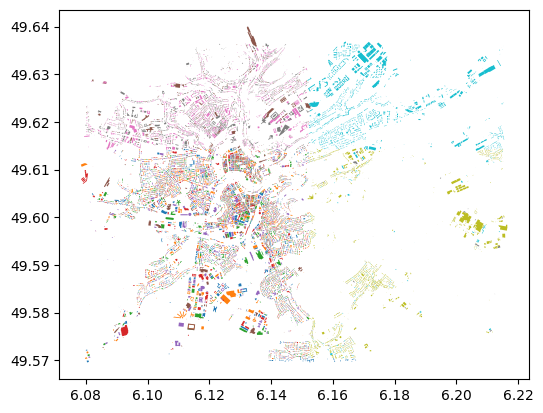

In [8]:
ddf_city_pd.head(18000).plot("geometry")

In [9]:
# saving only ID and geometry, because ShapeFile cannot handle lists
ddf_city_pd[['id','geometry']].to_file('test_overture_LU_buildings.shp')

## Places theme
Similarly we can read, plot and save the Places layer

In [10]:
path_LU_places = './../../../../s3/data/d011_overture/LU_2.parquet'
ddf_places = dask_geopandas.read_parquet(path_LU_places)
ddf_places.head(10)

,id,updatetime,version,names,categories,confidence,websites,socials,emails,phones,brand,addresses,sources,bbox,geometry,quadkey,country_iso
0,tmp_FC1221ED65D7ED46E3B321A14F1D4D73,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': None, 'main': 'wildlife_sanctuary'}",0.743291,None,{'list': ['https://www.facebook.com/3392220828...,None,None,"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.9713447, 'maxy': 50.1371892, 'minx'...",POINT (5.97134 50.13719),120203202031,LU
1,tmp_485B2BD1E00E31A0E83E48515D32F02E,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': None, 'main': 'bar_and_grill_res...",0.538296,None,{'list': ['https://www.facebook.com/1089121452...,None,None,"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.88459, 'maxy': 50.06587, 'minx': 5....",POINT (5.88459 50.06587),120203202032,LU
2,tmp_222046E3592335D56C0F8D83AA9F9B29,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': {'list': ['accommodation']}, 'ma...",0.709107,None,{'list': ['https://www.facebook.com/1630902113...,None,None,"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.9759905, 'maxy': 50.0702483, 'minx'...",POINT (5.97599 50.07025),120203202033,LU
3,tmp_761B6B52AA680DF41176E15E34FEE152,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': {'list': ['coffee_shop']}, 'main...",0.937052,None,{'list': ['https://www.facebook.com/1076529487...,None,{'list': ['+352621481900']},"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.92217, 'maxy': 50.09986, 'minx': 5....",POINT (5.92217 50.09986),120203202033,LU
4,tmp_B768BB31C668429FFC1B12A6D9D1BAA6,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': {'list': ['restaurant', 'museum'...",0.991387,{'list': ['http://www.hotelvieuxmoulin.lu']},{'list': ['https://www.facebook.com/1585107321...,None,{'list': ['+352998616']},"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.9643971, 'maxy': 50.0880888, 'minx'...",POINT (5.96440 50.08809),120203202033,LU
5,tmp_A3ADE8EB744605F9DE825B86923AA38B,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...",{'alternate': {'list': ['industrial_equipment'...,0.497155,None,{'list': ['https://www.facebook.com/1099819082...,None,{'list': ['+352621154214']},"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.97189, 'maxy': 50.09529, 'minx': 5....",POINT (5.97189 50.09529),120203202033,LU
6,tmp_543483A30235C68C85972333888A944C,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': None, 'main': 'church_cathedral'}",0.580950,None,{'list': ['https://www.facebook.com/2276756935...,None,None,"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.9722222, 'maxy': 50.0957778, 'minx'...",POINT (5.97222 50.09578),120203202033,LU
7,tmp_588AC95CC32EC3E1376FF70D2060454F,2023-07-24T00:00:00.000,0,"{'key_value': [{'key': 'common', 'value': {'li...","{'alternate': None, 'main': None}",0.600000,None,None,None,None,"{'names': None, 'wikidata': None}","{'list': [{'key_value': [{'key': 'locality', '...","{'list': [{'key_value': [{'key': 'dataset', 'v...","{'maxx': 5.9744224, 'maxy': 50.0960628, 'minx'...",POINT (5.97442 50.09606),120203202033,LU
8,tmp_D5A6F

This time we will save the entire dataset

In [11]:
gpd_places = ddf_places.compute()

<Axes: >

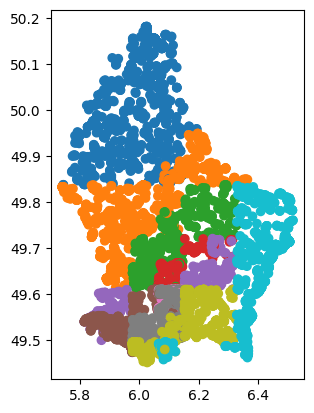

In [12]:
gpd_places.plot("geometry")

In [13]:
gpd_places[['id', 'geometry']].to_file('test_overture_LU_places.shp')